In [5]:
import sys
sys.path.append('..')
from models.scnn_pytorch.model import SCNN
from models.erfnet.erfnet import ERFNet
import torch
import os
import cv2
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt

In [6]:
def GetRectFromRegion(region: np.array, width, height):
    x = float(width) * region[0]
    y = float(height) * region[1]
    region_width = float(width) * region[2]
    region_height = float(height) * region[3]
    return np.array([x, y, region_width, region_height], dtype=np.int)

drive_window_region = np.array([600.0 / 1920, 280.0 / 1080, 1000.0 / 1920, 360.0 / 1080])
# drive_window_region = np.array([600.0 / 1920, 280.0 / 1080, 700.0 / 1920, 360.0 / 1080])


rect = GetRectFromRegion(drive_window_region, 1920, 1080)

In [13]:
# prepare engine

erf_net = ERFNet(5)
input_mean = erf_net.input_mean
input_std = erf_net.input_std
erf_net = torch.nn.DataParallel(erf_net, device_ids=[0]).cuda()
checkpoint = torch.load('D:/Dev/Codes-for-Lane-Detection/ERFNet-CULane-PyTorch/trained/ERFNet_trained.tar')
erf_net.load_state_dict(checkpoint['state_dict'])
erf_net.eval()
pass

#scnn
MODEL_DIR = '../models/scnn_pytorch'
INPUT_SIZE = (800, 288)
scnn_net = SCNN(input_size=INPUT_SIZE, pretrained=False, test=True)
state = torch.load("D:/DHH/Downloads/exp10_best.pth")
scnn_net.load_state_dict(state['net'])
scnn_net.eval().cuda().half()
mean = (0.3598, 0.3653, 0.3662)
std = (0.2573, 0.2663, 0.2756)

In [8]:
lanes = []
img = cv2.imread('../images/1591496847840.png')
drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
drive_window_img = drive_window_img.astype(np.float)

#erf_net
input_blob = (drive_window_img.copy() - input_mean) / input_std
input_blob = cv2.resize(input_blob, (976, 208))
input_blob = input_blob.transpose([2, 0, 1])

input_tensor = torch.from_numpy(np.array([input_blob]))
input_tensor = input_tensor.float().cuda()
seg, exist = erf_net(input_tensor)
seg = seg.detach().cpu().numpy()
erf_seg_img = np.argmax(seg[0], axis=0).astype(np.uint8)
erf_seg_img = cv2.resize(erf_seg_img, (1280, 720), interpolation=cv2.INTER_NEAREST)

for i in range(1,5):
    lanes.append(cv2.inRange(erf_seg_img, i, i))


#scnn
input_blob = drive_window_img.copy() / 255.0
input_blob = (input_blob - mean) / std
input_blob = cv2.resize(input_blob, INPUT_SIZE)
input_blob = input_blob.transpose([2, 0, 1])

input_tensor = torch.from_numpy(np.array([input_blob]))
input_tensor = input_tensor.float().cuda().half()

seg, exist = scnn_net(input_tensor)
scnn_seg_img = seg.cpu().numpy().astype(np.uint8)
scnn_seg_img = cv2.resize(scnn_seg_img, (1280, 720), interpolation=cv2.INTER_NEAREST)

for i in range(1,5):
    lanes[i-1] = lanes[i-1] + (cv2.inRange(scnn_seg_img, i, i))

merge_seg_img = scnn_seg_img + erf_seg_img

merge_seg_rgb_img = cv2.cvtColor(merge_seg_img, cv2.COLOR_GRAY2RGB)
merge_seg_rgb_img = cv2.resize(merge_seg_rgb_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
drive_window_img = cv2.resize(drive_window_img, (1280, 720))
blend = cv2.addWeighted(merge_seg_rgb_img * 30, 0.5, drive_window_img.astype(np.uint8), 0.8, 0)

plt.imshow(blend)

TypeError: 'NoneType' object is not subscriptable

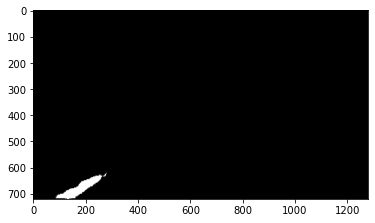

In [5]:
plt.imshow(erf_seg_img, cmap='gray')

In [6]:
i = 0
cv2.namedWindow("lane")
while(1):
    cv2.imshow("lane", lanes[i])
    cv2.setWindowTitle("lane", "lane" + str(i+1))
    if cv2.waitKey(500) == 27:
        break
    i = (i+1) % 4
cv2.destroyAllWindows()

In [24]:
example = torch.rand(1, 3, 976, 208)
erf_net = ERFNet(5)
input_mean = erf_net.input_mean
input_std = erf_net.input_std

weights = torch.load('D:/Dev/Codes-for-Lane-Detection/ERFNet-CULane-PyTorch/trained/ERFNet_trained.tar')['state_dict']
weights = {k.replace("module.", ""):v for k,v in weights.items()}
erf_net.load_state_dict(weights)
# erf_net = torch.nn.DataParallel(erf_net, device_ids=[0])
# checkpoint = torch.load('D:/Dev/Codes-for-Lane-Detection/ERFNet-CULane-PyTorch/trained/ERFNet_trained.tar')
# erf_net.load_state_dict(checkpoint['state_dict'])
erf_net.eval()
traced_script_module = torch.jit.trace(erf_net, example)
traced_script_module.save("erf_net.pt")

C:\Users\DHH\miniconda3\envs\ets2\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [12]:
# An instance of your model.
model = torchvision.models.resnet18()

# An example input you would normally provide to your model's forward() method.
example = torch.rand(1, 3, 224, 224)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example)

In [30]:
example = torch.rand(1, 3, 800, 288).half()
#scnn
MODEL_DIR = '../models/scnn_pytorch'
INPUT_SIZE = (800, 288)
scnn_net = SCNN(input_size=INPUT_SIZE, pretrained=False, test=True)
state = torch.load("D:/DHH/Downloads/exp10_best.pth")
scnn_net.load_state_dict(state['net'])
scnn_net.eval().half()
mean = (0.3598, 0.3653, 0.3662)
std = (0.2573, 0.2663, 0.2756)
traced_script_module = torch.jit.trace(scnn_net, example)
traced_script_module.save("scnn_net.pt")

RuntimeError: "unfolded2d_copy" not implemented for 'Half'